#### **Import Libraries**

In [1]:
import os 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import numpy as np 
import random 
import math
from itertools import chain
from IPython.display import display, Markdown
import textwrap
import tiktoken
import csv
import time 
import pandas as pd 
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
import transformers
from transformers import DataCollatorWithPadding
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict
import seaborn as sns 

In [2]:
seed = 0 

In [3]:
np.random.seed(seed)

#### **Set Up Paths**

In [4]:
data_csv = './../../../toy-data/exp2/data_1.csv'

#### **Set Up Plotting**

In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_36pt/Newsreader_36pt-Bold.ttf


#### Read in Data

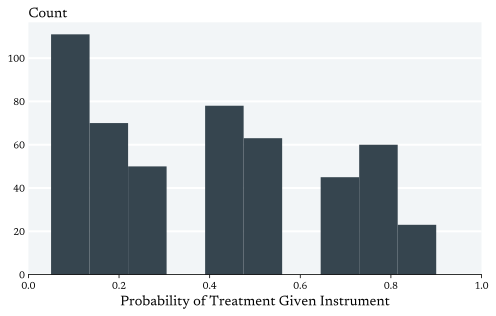

In [6]:

df = pd.read_csv(data_csv)
def fstage(race, gender, rent, health, fault):
    return 0.05 + 0.1*race + 0.2*race*fault + 0.1*race*gender + 0.1*health *fault * fault + 0.35*fault 
df['FStage_Value'] = df.apply(lambda row: fstage(row['Race'], row['Gender'], row['Rent'], row['Health'], row['Fault']), axis=1)
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

#### **Generate Outcome Data**

In [7]:
# Assuming df already exists and has the correct 'Stage_Value' column
n = len(df)  # Get the number of rows in df

# Assign the 'Instrument' column
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=n)

# Update the Description
df['Description'] = df.apply(lambda row: row['Description'] + " The tenant has access to a free lawyer" if row['Instrument'] == 1 else row['Description'], axis=1)

# Calculate probability based on 'Stage_Value' and 'Instrument'
base_prob = 0.5  # This is an example base probability
df['Treatment'] = np.random.binomial(n=1, p= 0.* (1-df['Instrument']) +  df['FStage_Value'] * df['Instrument'], size=n)
df['Outcome'] = np.random.binomial(n=1, p=df['Treatment'] * 0.5 + 0.25, size=n)

#### **Set Up Device**

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Tokenizer**

In [9]:
model_id = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.model_max_length = 512
print(tokenizer.model_max_length)

def tokenizer_function(example):
  return tokenizer(example["Description"], truncation=True)

/home/ubuntu/llmft/llms/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


512


In [10]:
df = df.rename(columns={'Treatment': 'label'})

In [11]:
original_dataset = Dataset.from_dict(df[['Description','label']])
tokenized_dataset = original_dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['Description'])
tokenized_dataset_split = tokenized_dataset.train_test_split(test_size=0.5, seed=42)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

#### **Hyperparameters**

In [12]:
lr = 1e-5
warmup_ratio = 0.25
batch_size = 32
epochs = 30
patience = float('inf') 
gamma = 0.0

#### **DataLoaders**

In [13]:
all_loader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
train_loader = DataLoader(tokenized_dataset_split['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset_split['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

#### **Model**

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           num_labels=2)
model = model.to(device)
#model = torch.compile(model)

/home/ubuntu/llmft/llms/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Optimizer and Scheduler**

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler =transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(warmup_ratio*len(train_loader)*epochs), len(train_loader)*epochs)

In [16]:
class_weights = torch.tensor([1., 1.], device=device) 
criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='output')

#### **Trainer**

In [17]:
yuri = EncoderTrainer(model, optimizer, scheduler, compute_recall, criterion, device, False)
early_stopping = EarlyStopping(patience)

In [18]:
# Compute Initial Train/Validation Losses
evaluation_losses = [yuri.evaluate(test_loader)]
training_losses =  [yuri.evaluate(train_loader)]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f}')

# Initialize Empty Lists to Store Recall and Learning Rate Histories
metric_history = []
learning_rate_history = []

for epoch in pbar:

    train_loss, (recall, _), current_lr = yuri.train(train_loader)

    training_losses.append(train_loss)
    metric_history.append(recall)
    learning_rate_history.append(current_lr)
    
    val_loss = yuri.evaluate(test_loader)
    evaluation_losses.append(val_loss)

    # Update the progress bar description for the current epoch
    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    
    # Call early stopping
    early_stopping(val_loss, model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break

model.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 30, Train Loss: 0.1340, Val Loss: 0.3077: 100%|██████████| 30/30 [02:26<00:00,  4.88s/it]


<All keys matched successfully>

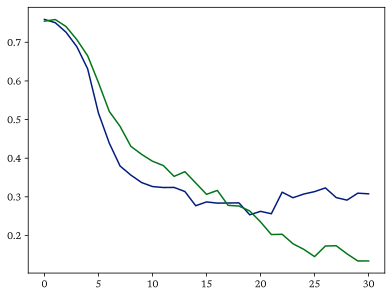

In [19]:
plt.plot(evaluation_losses)
plt.plot(training_losses)
plt.show()

In [20]:
Dhat , labels = predict(model, all_loader, device)

In [21]:
(labels == df['label']).all()

True

/tmp/ipykernel_26930/2939110060.py:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot((df['FStage_Value']*df['label'])[df['label']==0], color='purple', fill=True, bw_adjust=0.5)


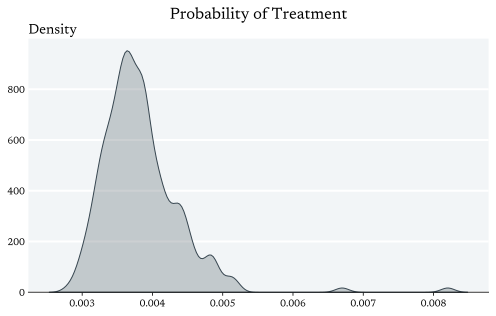

In [30]:
# Create figure and axes with specific settings
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Probability of Treatment', size=16, pad=20)

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

# Plot the KDE plot
sns.kdeplot(Dhat[df['Instrument']==0], color='#36454F', fill=True, bw_adjust=0.5)
sns.kdeplot((df['FStage_Value']*df['label'])[df['label']==0], color='purple', fill=True, bw_adjust=0.5)
plt.ylabel('')
plt.show()

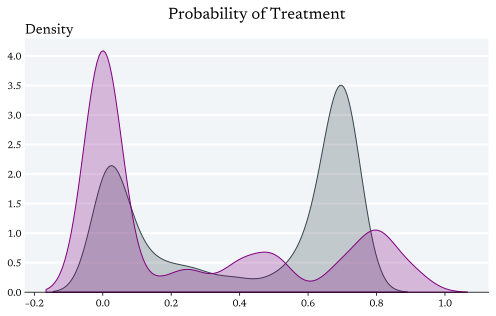

In [32]:
# Create figure and axes with specific settings
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Probability of Treatment', size=16, pad=20)

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

# Plot the KDE plot
sns.kdeplot(Dhat[df['Instrument']==1], color='#36454F', fill=True, bw_adjust=0.5)
sns.kdeplot((df['FStage_Value']*df['label'])[df['Instrument']==1], color='purple', fill=True, bw_adjust=0.5)
plt.ylabel('')
plt.show()

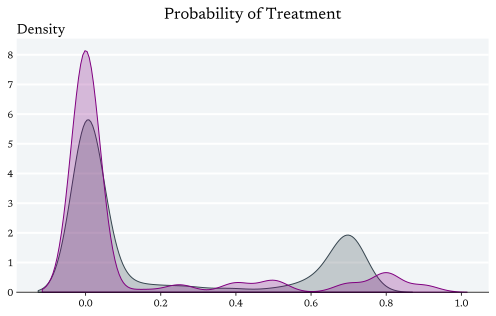

In [33]:
# Create figure and axes with specific settings
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Probability of Treatment', size=16, pad=20)

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

# Plot the KDE plot
sns.kdeplot(Dhat, color='#36454F', fill=True, bw_adjust=0.5)
sns.kdeplot(df['FStage_Value']*df['label'], color='purple', fill=True, bw_adjust=0.5)
plt.ylabel('')
plt.show()

#### **Save Results**

In [38]:
import pandas as pd

# Assuming df is your DataFrame and Dhat is already defined in your context
df['Residuals'] = df['label'] - Dhat

# Define the path for the CSV file
file_path = './../../../toy-data/exp2/results/llms_combined_results.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df[['Outcome', 'Residuals']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df[['Outcome', 'Residuals']].to_csv(file_path, mode='a', header=False, index=False)
